In [20]:
import os
import re
import json
import codecs
import gc
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import Counter
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.neighbors import DistanceMetric
from metric_learn import ITML_Supervised, Covariance, LSML, LSML_Supervised
from sklearn.metrics.pairwise import pairwise_distances as pdist
# import delta
from xgboost import XGBRegressor, plot_importance

from scripts.utils import *
from scripts.readability_functions import *

In [2]:
dir_in_parsed = 'parsed_json_cut_chunks'
dir_in_raw = 'json_cut_chunks15'
dir_in_ridero_parsed = 'parsed_json_cut_chunks'
dir_in_ridero_raw = 'json_cut_chunks15'

In [4]:
catalog = pd.read_csv('collection_catalog_full_final.csv', sep=';')
with open('stop3grams.txt', 'r') as f:
    stop3grams = set([s.lower() for s in f.read().splitlines()])

In [5]:
len(stop3grams)

4559

In [6]:
# def get_author_id(fbusta_id, catalog):
#     return catalog.loc[catalog['fbusta_id'] == fbusta_id]['author_id'].item()

In [7]:
# def get_author_name(fbusta_id, catalog):
# #     return catalog.loc[catalog['fbusta_id'] == book_id]['author_name'].item() + \
#     return catalog.loc[catalog['fbusta_id'] == fbusta_id]['author_surname'].item()


In [8]:
# def get_book_name(fbusta_id, catalog):
#     return catalog.loc[catalog['fbusta_id'] == fbusta_id]['book_title'].item()

In [9]:
# def get_book_id(fbusta_id, catalog):
#     return catalog.loc[catalog['fbusta_id'] == fbusta_id]['book_id'].item()

In [10]:
authors = []
book_names = []
book_fbusta_ids = []
book_ids = []
for filename in sorted(os.listdir(dir_in_parsed)):
    with open(os.path.join(dir_in_parsed, filename), 'r') as book:
        fbusta_id = int(filename.split('.')[0])
        book_fbusta_ids.append(fbusta_id)
        book_ids.append(get_book_id(fbusta_id, catalog))
        authors.append(get_author_id(fbusta_id, catalog))
        book_names.append(get_book_name(fbusta_id, catalog))
book_fbusta_ids = np.array(book_fbusta_ids)
book_names = np.array(book_names)
authors = np.array(authors)
book_ids = np.array(book_ids)

In [11]:
gc.collect()

20

In [12]:
len(authors)

2338

In [13]:
groups = pd.Series(authors).value_counts()
singles = np.array(groups[groups==1].index)
singles

array([], dtype=int64)

In [14]:
authors = np.array([a for a in authors if a not in singles])
len(authors)

2338

In [15]:
pd.Series(authors).value_counts().value_counts()

16    33
20    32
12    15
24    11
8      6
4      5
19     5
13     5
10     4
14     4
15     4
17     4
18     3
11     3
22     2
9      2
32     1
21     1
28     1
6      1
5      1
33     1
dtype: int64

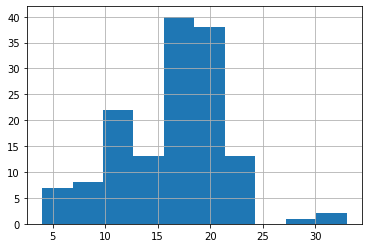

In [16]:
%matplotlib inline
pd.Series(authors).value_counts().hist()

In [17]:
def metric(M):
    return lambda x, y: (x-y).dot(M).dot(x-y)

In [18]:
def r_precision_m(matrix, authors, verbose=False):
    result = []
    for col in matrix:
        true_R = sum(authors == authors[col]) - 1
        
        closest = authors[matrix[col].argsort()][1:true_R+1]
        rp = sum(closest == authors[col]) / true_R
        if verbose:
            print(authors[col], closest, true_R, rp)
        result.append(rp)
    return result

In [26]:
def r_precision10_m(matrix, authors, verbose=False):
    result = []
    for col in matrix:
        true_R = sum(authors == authors[col]) - 1
        
        closest = authors[matrix[col].argsort()][1:11]
        rp = sum(closest == authors[col]) / true_R
        if verbose:
            print(authors[col], closest, true_R, rp)
        result.append(rp)
    return result

In [20]:
SAME_BOOK = 4
SAME_AUTHOR = 3
SAME_AGE = 2
LINKS_BOOKS = 1
LINKS_AUTHORS = 1
OTHER = 0

In [22]:
rel_matrix = pd.DataFrame(np.zeros((catalog.shape[0], catalog.shape[0])))
rel_matrix.columns = catalog['book_id']
rel_matrix.index = rel_matrix.columns

In [280]:
%%time
for i in range(catalog.shape[0]):
    row = catalog.iloc[i]
    rel_matrix.iloc[i, i] = SAME_BOOK
    for j in range(i+1, catalog.shape[0]):
        row2 = catalog.iloc[j]
        assert row2.book_id.item() == rel_matrix.iloc[j].name
        if rel_matrix.iloc[i, j] != 0:
#             print(i, j, 'zaneto', rel_matrix.iloc[i, j])
            continue
        if row.author_id.item() == row2.author_id.item():
            rel_matrix.iloc[i, j] = SAME_AUTHOR
            rel_matrix.iloc[j, i] = SAME_AUTHOR
#             print(i, j, 'author', rel_matrix.iloc[i, j])
        elif abs(row.year.item() - row2.year.item()) < 10:
            rel_matrix.iloc[i, j] = SAME_AGE
            rel_matrix.iloc[j, i] = SAME_AGE
#             print(i, j, 'age', rel_matrix.iloc[i, j])
        elif str(row.book_id) in str(row2.book_com_links).split('_'):
            rel_matrix.iloc[i, j] = LINKS_BOOKS
            rel_matrix.iloc[j, i] = LINKS_BOOKS
#             print(i, j, 'books', rel_matrix.iloc[i, j])
        elif str(row.author_id) in str(row2.author_com_links).split('_'):
            rel_matrix.iloc[i, j] = LINKS_AUTHORS
            rel_matrix.iloc[j, i] = LINKS_AUTHORS
#             print(i, j, 'authors', rel_matrix.iloc[i, j])
#         else:
#             print(i, j, 'none', rel_matrix.iloc[i, j])

CPU times: user 2min 48s, sys: 29.9 ms, total: 2min 48s
Wall time: 2min 48s


In [340]:
true_rel_row = sorted(rel_matrix[2].value_counts().items(), reverse=True)
k, v = true_rel_row[0]
true_rel_row[0] = (k, v-1)
true_rel_row

i = 0
idcg = 0
for k, v in true_rel_row:
    if not k:
        break
    for j in range(v):
        i += 1
        idcg += (2 ** k - 1) / np.log2(i+1)
        
idcg, i, (rel_matrix[2] > 0).sum()-1

(67.69750883827172, 98, 98)

In [367]:
def ndcg_m(dists, book_ids, catalog=catalog, verbose=False):
    result = []
    for col in dists:
        print(book_ids[col])
        if book_ids[col] == 303:
            continue
        p = (rel_matrix[book_ids[col]] > 0).sum() - 1
        cur_book_info = catalog[catalog['book_id'] == book_ids[col]]
        closest = book_ids[dists[col].argsort()][1:p+1]
        dcg = 0
        for i, book_id in enumerate(closest):
            book_info = catalog[catalog['book_id'] == book_id]
            if book_id == 303:
                continue
            if book_id == cur_book_info['book_id'].item():
                rel = SAME_BOOK
            elif cur_book_info['author_id'].item() == book_info['author_id'].item():
                rel = SAME_AUTHOR
            elif abs(cur_book_info['year'].item() - book_info['year'].item()) < 10:
                rel = SAME_AGE
            elif str(book_id) in str(cur_book_info['book_com_links'].item()).split('_'):
                rel = LINKS_BOOKS
            elif str(book_info['author_id'].item()) in str(cur_book_info['author_com_links'].item()).split('_'):
                rel = LINKS_AUTHORS
            else:
                rel = OTHER
            dcg += (2 ** rel - 1) / np.log2(i+2)
        
        i = 0
        idcg = 0
        true_rel_row = sorted(rel_matrix[book_ids[col]].value_counts().items(), reverse=True)
        k, v = true_rel_row[0]
        true_rel_row[0] = (k, v-1)
        for k, v in true_rel_row:
            if not k:
                break
            for j in range(v):
                i += 1
                idcg += (2 ** k - 1) / np.log2(i+1)
        assert p == i
        result.append(dcg / idcg)
        
    return result

In [368]:
catalog[catalog.book_id == 30]

,Unnamed: 0,author_surname,fbusta_id,author_id,author_name,book_id,book_title,polka_title,size,year,wiki_book,wiki_author,author_com_links,book_com_links
38,38,Андреев,288557,6,Леонид Николаевич,30,Иуда Искариот,NaN,60,1907.0,https://ru.wikipedia.org/wiki/Иуда_Искариот_(п...,"https://ru.wikipedia.org/wiki/Андреев,_Леонид_...",54_26_52_22,32_34_31


In [369]:
%%time
ndcg_m(pd.DataFrame(dist_xgb_train), book_ids_train, catalog)

2
1
4
1
3
2
2
4
7
9
5
5
7
6
6
8
7
5
13
14
12
13
13
12
11
11
10
10
16
16
17
16
18
18
16
15
17
18
20
22
20
22
24
21
21
25
27
21
26
23
23
27
26
25
34
28
32
28
32
34
32
31
30
33
33
37
37
35
36
35
35
39
36
38
37
44
41
42
40
40
41
42
42
47
45
45
47
49
47
48
49
47
48
52
51
51
50
52
50
53
53
54
53
55
57
58
58
59
60
60
59
61
60
62
62
65
64
63
64
64
63
69
66
69
68
66
70
66
67
69
71
73
72
75
74
74
72
73
75
75
82
78
79
78
78
81
80
79
82
81
81
77
86
84
85
85
86
84
87
84
83
85
91
92
89
90
88
89
90
88
92
91
98
96
95
97
93
97
96
95
94
96
98
106
101
107
102
99
106
99
102
106
102
100
103
105
103
103
105
105
105
111
110
109
113
111
112
109
113
108
110
109
108
118
120
117
118
116
117
120
117
118
124
124
124
123
122
122
126
125
127
126
125
126
129
129
128
128
129
136
137
135
137
133
133
135
134
135
136
138
138
143
142
139
141
141
142
141
140
141
139
145
144
146
147
146
144
147
146
148
149
148
149
150
152
151
152
152
151
153
153
155
156
154
156
157
156
157
154
158
158
162
162
159
161
161
160
161
163
166
166

[0.19905981690194083,
 0.179120637125413,
 0.18846082680254775,
 0.10870740384737454,
 0.318188948099461,
 0.3812329513441127,
 0.20609787026432932,
 0.25641237177348597,
 0.08697870408721267,
 0.09513287862525484,
 0.08785373537560331,
 0.240239526933179,
 0.06733925124902393,
 0.22402906526118405,
 0.03884653004886332,
 0.054904429925066923,
 0.15175352658169625,
 0.2481324668620943,
 0.09763334455068114,
 0.10579287450065171,
 0.04268676364868686,
 0.0,
 0.3157644265580898,
 0.24574315355994697,
 0.3117075846660475,
 0.8406586943262788,
 0.1784758209244809,
 0.0867598957265661,
 0.32883720014477175,
 0.1244788975492593,
 0.1054281574843961,
 0.3102873350688905,
 0.11999096444686981,
 0.1839867632574725,
 0.19041951414243866,
 0.10553664115086539,
 0.1374710257372214,
 0.15553553673790516,
 0.18866532031573038,
 0.0740746655894307,
 0.2920490281087141,
 0.043131856403280204,
 0.0,
 0.09988998606646039,
 0.18368492770047123,
 0.0,
 0.0,
 0.13795025383637083,
 0.0,
 0.13849493509166388

### Train test grouped split

In [19]:
def train_test_split(data, authors, test_size=.2, mod='grouped', random_state=17, return_idx=False):
    np.random.seed(random_state)
    uniques = np.unique(authors)
    if mod == 'grouped':
        test_authors = np.random.choice(uniques, int(len(uniques)*test_size), replace=False)
        test_idx = np.hstack([np.where(authors == a)[0] for a in test_authors])
        train_idx = np.array([i for i in range(len(authors)) if i not in test_idx])
    elif mod == 'stratified' or mod == 's':
        dropped = []
        test_idx = []
        train_idx = []
        for author in uniques:
            a_idx = np.where(authors == author)[0]
            if len(a_idx) < 3:
                dropped.append(a_idx)
                continue
            if len(a_idx) % 2 != 0:
                bi = a_idx[0]
                train_idx.append(bi)
                test_idx.append(bi)
                a_idx = a_idx[1:]
            a_idx_train = np.random.choice(a_idx, len(a_idx) // 2, replace=False)
            a_idx_test = np.array([i for i in a_idx if i not in a_idx_train])
            train_idx.extend(a_idx_train)
            test_idx.extend(a_idx_test)
        test_idx = np.array(test_idx)
        train_idx = np.array(train_idx)
    fraction = len(test_idx) / len(authors)
    print("test_fraction:", fraction)
    if return_idx:
        return train_idx, test_idx
    return data[train_idx], authors[train_idx], data[test_idx], authors[test_idx]


# 3 pos

In [33]:
def count_n_grams(texts, n=3, stopgrams=[], max_features=None):
    cv = CountVectorizer(ngram_range=(n, n), token_pattern=u"(?u)\\b\\w+\\b", max_features=max_features)
    cv.fit(texts)
    for s in stopgrams:
        if s in cv.vocabulary_:
            del cv.vocabulary_[s]
    for i, s in enumerate(sorted(cv.vocabulary_)):
        cv.vocabulary_[s] = i
    transformed = cv.transform(texts)
    return transformed, cv

In [111]:
%%time

data = []
for filename in sorted(os.listdir(dir_in_parsed)):
    with open(os.path.join(dir_in_parsed, filename), 'r') as book:
        fbusta_id = int(filename.split('.')[0])
        if get_author_id(fbusta_id, catalog) not in singles:
            data.append(book.read())
data = np.array(data)
print(len(data))

2344
CPU times: user 2.31 s, sys: 132 ms, total: 2.44 s
Wall time: 2.64 s


In [40]:
idx_train, idx_test = train_test_split(data, authors, return_idx=True, mod='s')
data_train, y_train, data_test, y_test = data[idx_train], authors[idx_train], data[idx_test], authors[idx_test]
x_train_tri, cv_tri_grams = count_n_grams(data_train, n=3, stopgrams=stop3grams, max_features=5000) #5700
x_test_tri = cv_tri_grams.transform(data_test)
# tri_grams = normalize(tri_grams, norm='l1')

2344
test_fraction: 0.5051194539249146
CPU times: user 10.5 s, sys: 200 ms, total: 10.7 s
Wall time: 10.7 s


In [41]:
x_train_tri

<1184x4381 sparse matrix of type '<class 'numpy.int64'>'
	with 1086965 stored elements in Compressed Sparse Row format>

In [42]:
del data
gc.collect()

40

In [23]:
df = pd.DataFrame(tri_grams.todense())
df.columns = sorted(cv_tri_grams.vocabulary_)

### 3 pos + covariance

In [97]:
ddf = df[df.std().sort_values()[-50:].index]
# ddf = df

In [112]:
%%time
cr = ddf.corr()
cr.loc[:,:] = np.tril(cr.abs().values, k=-1)
rr = cr[cr>0].unstack()
rr = rr[(~np.isnan(rr)) & (rr >= 0.8)]
# np.round(rr.sort_values(), 3)

CPU times: user 4min 15s, sys: 1.92 s, total: 4min 17s
Wall time: 4min 14s


In [276]:
df.drop([x[0] for x in d.index], inplace=True, axis=1)

In [102]:
d = np.round(rr.sort_values(), 3)

In [86]:
ddf = df[df.columns[(df.sum() > 100).values]]

In [103]:
d

s v spro          spro v spro         0.500
s conj vприч      vприч s conj        0.500
part spro part    part spro v         0.500
adv spro v        s spro v            0.500
s a a             vприч pr s          0.501
spro part spro    spro pr spro        0.501
spro pr spro      s pr spro           0.501
v a s             s v s               0.501
pr s apro         pr apro s           0.501
vприч s s         a s a               0.501
apro s apro       apro a s            0.501
part v spro       spro v spro         0.501
apro s spro       spro v pr           0.502
vдеепр pr a       vдеепр pr s         0.502
conj pr apro      apro s conj         0.502
part spro v       conj spro adv       0.502
part pr spro      spro pr spro        0.502
vдеепр s s        vдеепр s pr         0.502
s advpro part     advpro part v       0.502
part spro part    advpro part spro    0.502
spro apro a       v spro apro         0.502
conj a a          a s pr              0.503
apro s conj       v apro s      

In [34]:
book_names[249]

241407

In [98]:
# tri_grams = normalize(df, norm='l1')
# X = tri_grams
X = normalize(ddf, norm='l1')

In [99]:
idx_train, idx_test = train_test_split(X, authors, return_idx=True, mod='s')
x_train, y_train, x_test, y_test = X[idx_train], authors[idx_train], X[idx_test], authors[idx_test]

test_fraction: 0.546191247974068


In [100]:
scaler = StandardScaler().fit(x_train)
x_train_sc = scaler.transform(x_train)
x_test_sc = scaler.transform(x_test)

In [440]:
# from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
# skb = SelectKBest(mutual_info_classif, k=50)
# skb.fit(x_train_sc, y_train)
# x_train_sc = skb.transform(x_train_sc)

In [101]:
x_train_sc.shape

(337, 50)

In [102]:
%%time
sk_cov_metric = DistanceMetric.get_metric('mahalanobis', V=np.cov(x_train_sc.T))

CPU times: user 42.1 ms, sys: 12 ms, total: 54.1 ms
Wall time: 13.7 ms


In [103]:
%%time
distances = sk_cov_metric.pairwise(x_train_sc)

CPU times: user 206 ms, sys: 4 µs, total: 206 ms
Wall time: 204 ms


In [78]:
np.linalg.det(np.cov(x_train_sc.T))

0.0

In [104]:
np.array(r_precision_m(authors=y_train, matrix=pd.DataFrame(distances))).mean()

0.1592482690405539

In [105]:
%%time
# x_test_sc = skb.transform(x_test_sc)
test_distances = sk_cov_metric.pairwise(x_test_sc)

CPU times: user 132 ms, sys: 3.99 ms, total: 136 ms
Wall time: 135 ms


In [106]:
np.array(r_precision_m(authors=y_test, matrix=pd.DataFrame(test_distances))).mean()

0.1347675568743818

In [95]:
np.isnan(test_distances).sum()

55266

In [452]:
x_test_sc.shape

(115, 50)

### 3pos + xgb

In [50]:
x_train_tri = normalize(x_train_tri, norm='l1').todense()
x_test_tri = x_test_tri.todense()
book_ids_train, book_ids_test = book_ids[idx_train], book_ids[idx_test]

scaler = StandardScaler().fit(x_train_tri)
x_train_sc = scaler.transform(x_train_tri)
x_test_sc = scaler.transform(x_test_tri)

/home/artesby/anaconda3/envs/myenv/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [51]:
%%time
eu_train_matrix = pdist(x_train_sc)
eu_test_matrix = pdist(x_test_sc)
print("eu train rpec:", np.mean(r_precision_m(matrix=pd.DataFrame(eu_train_matrix), authors=y_train)))
print("eu test rpec:", np.mean(r_precision_m(matrix=pd.DataFrame(eu_test_matrix), authors=y_test)))

eu train rpec: 0.05854078236890737
eu test rpec: 0.04102223086598087
CPU times: user 8.23 s, sys: 87.5 ms, total: 8.32 s
Wall time: 7.01 s


In [52]:
del eu_test_matrix
del eu_train_matrix
gc.collect()

674

In [53]:
np.random.seed(17)
CLOSE = 0
MID = 1
FAR = 2
positive = []
labels_positive = []
for i, x1 in enumerate(x_train_sc):
    for j, x2 in enumerate(x_train_sc):
        if book_ids_train[i] == book_ids_train[j] and i != j:
            positive.append( np.abs(x1 - x2) )
            labels_positive.append(CLOSE)
        elif y_train[i] == y_train[j] and i != j:
            positive.append( np.abs(x1 - x2) )
            labels_positive.append(MID)

negative = []
labels_negative = []
while len(negative) < len(positive):
    idx1, idx2 = np.random.choice(len(y_train), 2, replace=False)
    if y_train[idx1] == y_train[idx2]:
        continue
    negative.append(
        np.abs(x_train_sc[idx1] - x_train_sc[idx2])
    )
    labels_negative.append(FAR)

data_train = [*positive, *negative]
labels_train = [*labels_positive, *labels_negative]

positive_test = []
labels_positive_test = []
for i, x1 in enumerate(x_test_sc):
    for j, x2 in enumerate(x_test_sc):
        if book_ids_test[i] == book_ids_test[j] and i != j:
            positive_test.append( np.abs(x1 - x2) )
            labels_positive_test.append(CLOSE)
        elif y_test[i] == y_test[j] and i != j:
            positive_test.append( np.abs(x1 - x2) )
            labels_positive_test.append(MID)
            
negative_test = []
labels_negative_test = []
while len(negative_test) < len(positive_test):
    idx1, idx2 = np.random.choice(len(y_test), 2, replace=False)
    if y_test[idx1] == y_test[idx2]:
        continue
    negative_test.append(
        np.abs(x_test_sc[idx1] - x_test_sc[idx2])
    )
    labels_negative_test.append(FAR)
    
data_test = [*positive_test, *negative_test]
labels_test = [*labels_positive_test, *labels_negative_test]

eval_set = [(data_train, labels_train), (data_test, labels_test)]

In [56]:
from xgboost import XGBRegressor, plot_importance

In [67]:
xreg = XGBRegressor(objective ='reg:linear', n_jobs=1, booster='gbtree', 
              n_estimators=2000, subsample=0.8, colsample_by_tree=0.7)

In [68]:
%%time
xreg.fit(data_train,labels_train, eval_set=eval_set, early_stopping_rounds=50)

[0]	validation_0-rmse:1.07876	validation_1-rmse:1.06592
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:1.04188	validation_1-rmse:1.01564
[2]	validation_0-rmse:1.00757	validation_1-rmse:0.96946
[3]	validation_0-rmse:0.975412	validation_1-rmse:0.928914
[4]	validation_0-rmse:0.945359	validation_1-rmse:0.889878
[5]	validation_0-rmse:0.917384	validation_1-rmse:0.855297
[6]	validation_0-rmse:0.891256	validation_1-rmse:0.822343
[7]	validation_0-rmse:0.866792	validation_1-rmse:0.793271
[8]	validation_0-rmse:0.844162	validation_1-rmse:0.768395
[9]	validation_0-rmse:0.823031	validation_1-rmse:0.744401
[10]	validation_0-rmse:0.803287	validation_1-rmse:0.723853
[11]	validation_0-rmse:0.785049	validation_1-rmse:0.709368
[12]	validation_0-rmse:0.768046	validation_1-rmse:0.693227
[13]	validation_0-rmse:0.752306	validation_1-rmse:0.679519
[14]	validation_0-rmse:0.737594

XGBRegressor(base_score=0.5, booster='gbtree', colsample_by_tree=0.7,
       colsample_bylevel=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=2000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

In [69]:
%%time
dist_xgb_train = np.zeros((len(x_train_sc), len(x_train_sc)))
for i, x1 in enumerate(x_train_sc):
    for j, x2 in enumerate(x_train_sc):
        if dist_xgb_train[i][j] == 0:
            p = xreg.predict(np.abs([x1 - x2]))[0]
            dist_xgb_train[i][j] = p
            dist_xgb_train[j][i] = p

print("xgb train rpec:", np.mean(r_precision_m(matrix=pd.DataFrame(dist_xgb_train), authors=y_train)))

dist_xgb_test = np.zeros((len(x_test_sc), len(x_test_sc)))
for i, x1 in enumerate(x_test_sc):
    for j, x2 in enumerate(x_test_sc):
        if dist_xgb_test[i][j] == 0:
            p = xreg.predict(np.abs([x1 - x2]))[0]
            dist_xgb_test[i][j] = p
            dist_xgb_test[j][i] = p

print("xgb test rpec:", np.mean(r_precision_m(matrix=pd.DataFrame(dist_xgb_test), authors=y_test)))

xgb train rpec: 0.1222888468982219
xgb test rpec: 0.009104998558123559
CPU times: user 29min 24s, sys: 199 ms, total: 29min 25s
Wall time: 29min 25s


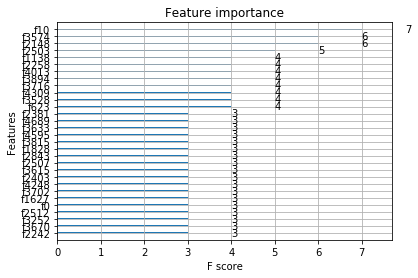

In [146]:
plot_importance(xreg, max_num_features=30)

In [145]:
df.columns[xreg.feature_importances_.argsort()[:10]]

Index(['pвнутр pвнутр nl', 'pтире advpro pгран', 'pтире advpro pвнутр',
       'pтире advpro pr', 'pтире advpro conj', 'pтире advpro apro',
       'pтире advpro advpro', 'pтире advpro pкавычки', 'pтире advpro adv',
       'pтире adv vприч'],
      dtype='object')

### 3pos + features from xgb + cov

In [291]:
x_features = xreg.feature_importances_

In [292]:
# columns = x_features > 0
columns = x_features.argsort()[-50:]

In [293]:
df = pd.DataFrame(normalize(tri_grams.todense(), norm='l1'))
df.columns = sorted(cv_tri_grams.vocabulary_)

In [294]:
df = df[df.columns[columns]]

In [295]:
X = np.array(df)
idx_train, idx_test = train_test_split(X, authors, return_idx=True)
x_train, y_train, x_test, y_test = X[idx_train], authors[idx_train], X[idx_test], authors[idx_test]

scaler = StandardScaler().fit(x_train)
x_train_sc = scaler.transform(x_train)
x_test_sc = scaler.transform(x_test)

test_fraction: 0.18638573743922204


In [296]:
%%time
sk_cov_metric = DistanceMetric.get_metric('mahalanobis', V=np.cov(x_train_sc.T))

CPU times: user 2.52 ms, sys: 0 ns, total: 2.52 ms
Wall time: 707 µs


In [297]:
%%time
distances = sk_cov_metric.pairwise(x_train_sc)

CPU times: user 461 ms, sys: 0 ns, total: 461 ms
Wall time: 290 ms


In [298]:
np.linalg.det(np.cov(x_train_sc.T))

3.424298646266824e-15

In [299]:
distances

array([[0.        , 9.39815864, 8.9480539 , ..., 7.01979552, 7.04437388,
        6.53056068],
       [9.39815864, 0.        , 9.64527917, ..., 8.80556814, 8.85322019,
        7.14251881],
       [8.9480539 , 9.64527917, 0.        , ..., 9.4508984 , 8.62625623,
        7.73862668],
       ...,
       [7.01979552, 8.80556814, 9.4508984 , ..., 0.        , 7.13602134,
        7.66938786],
       [7.04437388, 8.85322019, 8.62625623, ..., 7.13602134, 0.        ,
        6.56454605],
       [6.53056068, 7.14251881, 7.73862668, ..., 7.66938786, 6.56454605,
        0.        ]])

In [300]:
np.isnan(distances).sum()

0

In [301]:
np.array(r_precision_m(authors=y_train, matrix=pd.DataFrame(distances))).mean()

0.17018592297476762

In [302]:
%%time
# x_test_sc = skb.transform(x_test_sc)
test_distances = sk_cov_metric.pairwise(x_test_sc)

CPU times: user 15.2 ms, sys: 0 ns, total: 15.2 ms
Wall time: 15.2 ms


In [303]:
np.array(r_precision_m(authors=y_test, matrix=pd.DataFrame(test_distances))).mean()

0.3473913043478261

In [304]:
np.isnan(test_distances).sum()

0

In [305]:
x_test_sc.shape

(115, 50)

### 3pos + ITML

In [23]:
tri_grams = normalize(tri_grams, norm='l1')

X = tri_grams.todense()

idx_train, idx_test = train_test_split(X, authors, return_idx=True, mod='s')
x_train, y_train, x_test, y_test = X[idx_train], authors[idx_train], X[idx_test], authors[idx_test]

scaler = StandardScaler().fit(x_train)
x_train_sc = scaler.transform(x_train)
x_test_sc = scaler.transform(x_test)

test_fraction: 0.546191247974068


In [24]:
clf = ITML_Supervised(num_constraints=300, verbose=True, convergence_threshold=0.001, )

In [25]:
%%time
clf.fit(x_train_sc, y_train)

itml iter: 0, conv = 16.645941
itml iter: 1, conv = 1.452794
itml iter: 2, conv = 0.278795
itml iter: 3, conv = 0.065051
itml iter: 4, conv = 0.015902
itml iter: 5, conv = 0.003892
itml converged at iter: 6, conv = 0.000960
CPU times: user 57min 50s, sys: 7min 25s, total: 1h 5min 15s
Wall time: 16min 25s


ITML_Supervised(A0=None, bounds=None, convergence_threshold=0.001, gamma=1.0,
        max_iter=1000, num_constraints=300, num_labeled=inf, verbose=True)

In [26]:
i_metric = metric(clf.metric())

In [27]:
%%time
train_dist_matrix = pdist(x_train_sc, metric=i_metric)

CPU times: user 1h 14min 52s, sys: 18.8 s, total: 1h 15min 10s
Wall time: 18min 56s


In [31]:
np.mean(r_precision_m(authors=y_train, matrix=pd.DataFrame(train_dist_matrix)))

0.9169139465875371

In [40]:
y_train

array([  0,   0,   1,   1,   1,   2,   2,   2,   3,   3,   3,   5,   5,
         5,   6,   6,   6,   8,   8,   8,   9,   9,  10,  10,  10,  11,
        11,  12,  12,  12,  13,  13,  15,  15,  16,  16,  16,  17,  17,
        17,  19,  19,  19,  20,  20,  20,  21,  21,  21,  22,  22,  22,
        23,  23,  23,  24,  24,  25,  25,  25,  26,  26,  26,  27,  27,
        28,  28,  29,  29,  30,  30,  30,  32,  32,  32,  33,  33,  35,
        35,  37,  37,  37,  40,  40,  40,  41,  41,  41,  42,  42,  43,
        43,  44,  44,  44,  45,  45,  45,  46,  46,  46,  47,  47,  48,
        48,  48,  49,  49,  49,  50,  50,  50,  50,  50,  51,  51,  51,
        52,  52,  53,  53,  53,  54,  54,  54,  55,  55,  56,  56,  56,
        58,  58,  58,  59,  59,  59,  60,  60,  60,  61,  61,  62,  62,
        62,  63,  63,  64,  64,  64,  65,  65,  65,  66,  66,  66,  67,
        67,  69,  69,  69,  70,  70,  70,  71,  71,  72,  72,  73,  73,
        74,  74,  74,  75,  75,  77,  77,  78,  78,  79,  79,  7

In [29]:
%%time
test_dist_matrix = pdist(x_test_sc, metric=i_metric)

CPU times: user 1h 14min 32s, sys: 18.7 s, total: 1h 14min 51s
Wall time: 18min 49s


In [30]:
np.mean(r_precision_m(authors=y_test, matrix=pd.DataFrame(test_dist_matrix)))

0.11572700296735905

| method    	| test_rp 	| train_rp 	|
|-----------	|---------	|----------	|
| ITML(300) 	| 0,167   	|          	|
| ITML(500) 	| 0,153   	|          	|
| ITML(2000) 	| 0,164 	|          	|

### 3pos + LSML

In [41]:
prior = np.ones((len(x_train_sc), len(x_train_sc)))
for i, a1 in enumerate(y_train):
    for j, a2 in enumerate(y_train):
        if a1 == a2:
            prior[i][j] = 0
            prior[j][i] = 0

In [42]:
clf = LSML_Supervised(num_constraints=300, verbose=True, prior=prior)

In [43]:
%%time
clf.fit(x_train_sc, y_train)

LinAlgError: Singular matrix

In [437]:
y_train[460]

56

In [429]:
from metric_learn import Constraints
c = Constraints.random_subset(y_train, np.inf, random_state=np.random)
c.positive_negative_pairs(10)

(array([280, 479, 365, 293, 272, 472, 312,  76, 109, 458]),
 array([ 41,  43,  44, 292, 167, 473, 313, 485, 136, 489]),
 array([ 54,  12, 405, 376, 465, 244, 462, 285, 430, 125]),
 array([365, 460,  35,  99, 145, 329, 366, 302, 232, 251]))

### Удобочитаемые фичи

#### % диалогов

In [112]:
def dialog_fraction(parsed_json):
    return np.array([d.count('NL Pтире') / d.count('NL') for d in parsed_json]).reshape(-1, 1)

In [113]:
dia_frac = dialog_fraction(data)
dia_frac.shape

(2344, 1)

#### avg sentence length

In [114]:
punct_pos= [
    'Pвнутр', 'Pгран', 'Pтире', 'Pкавычки', 'NL',
]

def avg_sent_len_one(parsed_json):
    sentences = [[w for w in s.split() if w not in punct_pos] for s in re.split('NL|Pгран', parsed_json)]
    sentences_len = [len(s) for s in sentences if len(s) > 0]
    return sum(sentences_len) / len(sentences_len)

def avg_sent_len_many(parsed_jsons):
    return np.array([avg_sent_len_one(json) for json in parsed_jsons])
        

In [115]:
avg_sent_l = avg_sent_len_many(data).reshape(-1, 1)

In [116]:
avg_sent_l.shape

(2344, 1)

In [117]:
avg_sent_l.mean(), avg_sent_l.std()

(11.67605837665916, 4.713126782705324)

#### pos fractions

In [50]:
# def pos_fraction(parsed_json):
#     d = Counter(parsed_json.split())
#     for k in punct_pos:
#         del d[k]
#     total = sum(d.values())
#     for k in d:
#         d[k] /= total
#     return d

In [118]:
%%time
pos_fractions, cv_fractions = count_n_grams(data, n=1, stopgrams=[s.lower() for s in punct_pos])
pos_fractions = normalize(pos_fractions, norm='l1')

CPU times: user 6.81 s, sys: 0 ns, total: 6.81 s
Wall time: 6.81 s


In [119]:
pos_fractions

<2344x20 sparse matrix of type '<class 'numpy.float64'>'
	with 39500 stored elements in Compressed Sparse Row format>

#### avg word length

In [53]:
# def avg_word_len(json):
#     sum_len = 0
#     n_words = 0
#     for line in json:
#         if 'analysis' in line:
#             sum_len += len(line['text'])
#             n_words += 1
#     return sum_len / n_words

In [124]:
%%time
data = []
for filename in sorted(os.listdir(dir_in_raw)):
    book_id = int(filename.split('.')[0])
    if get_author_id(book_id, catalog) in singles:
        continue
    wl = 0
    wn = 0
    with codecs.open(os.path.join(dir_in_raw, filename), encoding='utf-8') as book:
        content = book.read()
        lines = [json.loads(l) for l in content.splitlines()]
        for line in lines:
            if 'analysis' in line:
                wl += len(line['text'])
                wn += 1
    data.append(wl / wn)


CPU times: user 1min 40s, sys: 376 ms, total: 1min 41s
Wall time: 1min 41s


In [125]:
avg_len_word = np.array(data).reshape(-1, 1)
avg_len_word.shape

(2344, 1)

In [126]:
avg_len_word.mean(), avg_len_word.std()

(5.241211620335765, 0.30312214853361935)

#### Type token ratio

In [120]:
def type_token_ratio(json):
    vocabulary = Counter()
    for line in json:
        if 'analysis' in line and line['analysis']:
            if 'lex' in line['analysis'][0]:
                word = line['analysis'][0]['lex']
                vocabulary[word] += 1
    return len(vocabulary) / sum(vocabulary.values())

In [121]:
%%time
data = []
for filename in sorted(os.listdir(dir_in_raw)):
    book_id = int(filename.split('.')[0])
    if get_author_id(book_id, catalog) in singles:
        continue
    with codecs.open(os.path.join(dir_in_raw, filename), encoding='utf-8') as book:
        content = book.read()
        lines = [json.loads(l) for l in content.splitlines()]
        data.append(type_token_ratio(lines))

CPU times: user 1min 48s, sys: 324 ms, total: 1min 49s
Wall time: 1min 49s


In [122]:
type_token_ratio = np.array(data).reshape(-1, 1)
type_token_ratio.shape

(2344, 1)

In [123]:
type_token_ratio.mean(), type_token_ratio.std()

(0.4211732502969508, 0.05659772891845692)

#### %  редких слов

In [127]:
threshold = 10
ncrl = pd.read_csv('1grams-3.txt', sep='\t', header=None)
ncrl = ncrl[(ncrl[0] > threshold)]
def is_russian_alpha(word):
    return re.match('[а-яА-Я]', str(word))
rare_words = set(w.lower() for w in ncrl[1] if is_russian_alpha(w))
len(rare_words)

413942

In [128]:
def rare_words_fraction(json, rare_words=set()):
    n_rare = 0
    n_all = 0
    for line in json:
        if 'analysis' in line:
            n_all += 1
            if line['text'].lower() not in rare_words:
                n_rare += 1
            elif ( 
                line['analysis']
                and 'lex' in line['analysis'][0]
                and line['analysis'][0]['lex'] not in rare_words):
                n_rare += 1
    return n_rare / n_all

In [129]:
%%time
data = []
for filename in sorted(os.listdir(dir_in_raw)):
    book_id = int(filename.split('.')[0])
    if get_author_id(book_id, catalog) in singles:
        continue
    with codecs.open(os.path.join(dir_in_raw, filename), encoding='utf-8') as book:
        content = book.read()
        lines = [json.loads(l) for l in content.splitlines()]
        data.append(rare_words_fraction(lines, rare_words))

CPU times: user 1min 31s, sys: 296 ms, total: 1min 31s
Wall time: 1min 32s


In [130]:
rwf = np.array(data).reshape(-1, 1)
rwf.shape

(2344, 1)

In [131]:
rwf.mean(), rwf.std()

(0.03267780385513211, 0.016042752727964068)

### удобочитаемые + cov

In [132]:
X = np.c_[pos_fractions.toarray(), avg_sent_l, avg_len_word, type_token_ratio, rwf, dia_frac]

In [133]:
X.shape

(2344, 25)

In [134]:
idx_train, idx_test = train_test_split(X, authors, return_idx=True, mod='s')
x_train, y_train, x_test, y_test = X[idx_train], authors[idx_train], X[idx_test], authors[idx_test]
book_ids_train, book_ids_test = book_ids[idx_train], book_ids[idx_test]

test_fraction: 0.5051194539249146


In [135]:
scaler = StandardScaler().fit(x_train)
x_train_sc = scaler.transform(x_train)
x_test_sc = scaler.transform(x_test)

In [136]:
%%time
eu_train_matrix = pdist(x_train_sc)
eu_test_matrix = pdist(x_test_sc)
print("eu train rpec:", np.mean(r_precision_m(matrix=pd.DataFrame(eu_train_matrix), authors=y_train)))
print("eu test rpec:", np.mean(r_precision_m(matrix=pd.DataFrame(eu_test_matrix), authors=y_test)))

eu train rpec: 0.1593026260995011
eu test rpec: 0.1761742375023625
CPU times: user 6.9 s, sys: 7.96 ms, total: 6.91 s
Wall time: 6.91 s


In [137]:
%%time
sk_cov_metric = DistanceMetric.get_metric('mahalanobis', V=np.cov(x_train_sc.T))

CPU times: user 2.85 ms, sys: 13 µs, total: 2.86 ms
Wall time: 1.71 ms


In [138]:
%%time
distances = sk_cov_metric.pairwise(x_train_sc)

CPU times: user 422 ms, sys: 5 µs, total: 422 ms
Wall time: 418 ms


In [139]:
np.array(r_precision_m(authors=y_train, matrix=pd.DataFrame(distances))).mean()

0.007913934085809086

In [140]:
test_dist =  sk_cov_metric.pairwise(x_test_sc)
np.array(r_precision_m(authors=y_test, matrix=pd.DataFrame(test_dist))).mean()

0.008463307291432293

In [141]:
np.isnan(distances).sum(), np.isnan(test_dist).sum()

(199160, 197736)

In [142]:
np.linalg.det(np.cov(x_train_sc.T))

-2.999238996186679e-22

### удобочитаемые + xgb

In [143]:
X = np.c_[pos_fractions.toarray(), avg_sent_l, avg_len_word, type_token_ratio, rwf, dia_frac]

idx_train, idx_test = train_test_split(X, authors, return_idx=True, mod='s')
x_train, y_train, x_test, y_test = X[idx_train], authors[idx_train], X[idx_test], authors[idx_test]
book_ids_train, book_ids_test = book_ids[idx_train], book_ids[idx_test]

scaler = StandardScaler().fit(x_train)
x_train_sc = scaler.transform(x_train)
x_test_sc = scaler.transform(x_test)

test_fraction: 0.5051194539249146


In [144]:
np.random.seed(17)
CLOSE = 0
MID = 1
FAR = 2
positive = []
labels_positive = []
for i, x1 in enumerate(x_train_sc):
    for j, x2 in enumerate(x_train_sc):
        if book_ids_train[i] == book_ids_train[j] and i != j:
            positive.append(
                np.abs(x1 - x2)
            )
            labels_positive.append(CLOSE)
        elif y_train[i] == y_train[j] and i != j:
            positive.append(
                np.abs(x1 - x2)
            )
            labels_positive.append(MID)

negative = []
labels_negative = []
while len(negative) < len(positive):
    idx1, idx2 = np.random.choice(len(y_train), 2, replace=False)
    if y_train[idx1] == y_train[idx2]:
        continue
    negative.append(
        np.abs(x_train_sc[idx1] - x_train_sc[idx2])
    )
    labels_negative.append(FAR)

data_train = [*positive, *negative]
labels_train = [*labels_positive, *labels_negative]

positive_test = []
labels_positive_test = []
for i, x1 in enumerate(x_test_sc):
    for j, x2 in enumerate(x_test_sc):
        if book_ids_test[i] == book_ids_test[j] and i != j:
            positive_test.append(
                np.abs(x1 - x2)
            )
            labels_positive_test.append(CLOSE)
        elif y_test[i] == y_test[j] and i != j:
            positive_test.append(
                np.abs(x1 - x2)
            )
            labels_positive_test.append(MID)
            
negative_test = []
labels_negative_test = []
while len(negative_test) < len(positive_test):
    idx1, idx2 = np.random.choice(len(y_test), 2, replace=False)
    if y_test[idx1] == y_test[idx2]:
        continue
    negative_test.append(
        np.abs(x_test_sc[idx1] - x_test_sc[idx2])
    )
    labels_negative_test.append(FAR)
    
data_test = [*positive_test, *negative_test]
labels_test = [*labels_positive_test, *labels_negative_test]

eval_set = [(data_train, labels_train), (data_test, labels_test)]

In [145]:
xreg = XGBRegressor(objective ='reg:linear', n_jobs=1, booster='gbtree', n_estimators=2000, subsample=0.7)

In [146]:
%%time
xreg.fit(data_train,labels_train, eval_set=eval_set, early_stopping_rounds=150)

[0]	validation_0-rmse:1.03787	validation_1-rmse:1.03913
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 150 rounds.
[1]	validation_0-rmse:0.967473	validation_1-rmse:0.969805
[2]	validation_0-rmse:0.906704	validation_1-rmse:0.909675
[3]	validation_0-rmse:0.854092	validation_1-rmse:0.857755
[4]	validation_0-rmse:0.808458	validation_1-rmse:0.812358
[5]	validation_0-rmse:0.768853	validation_1-rmse:0.773029
[6]	validation_0-rmse:0.735234	validation_1-rmse:0.739622
[7]	validation_0-rmse:0.705837	validation_1-rmse:0.710652
[8]	validation_0-rmse:0.680938	validation_1-rmse:0.686302
[9]	validation_0-rmse:0.659411	validation_1-rmse:0.664933
[10]	validation_0-rmse:0.641133	validation_1-rmse:0.647085
[11]	validation_0-rmse:0.625597	validation_1-rmse:0.631876
[12]	validation_0-rmse:0.612426	validation_1-rmse:0.618948
[13]	validation_0-rmse:0.600601	validation_1-rmse:0.607486
[14]	validation_0-rmse:0.5

[137]	validation_0-rmse:0.488239	validation_1-rmse:0.526311
[138]	validation_0-rmse:0.487995	validation_1-rmse:0.526315
[139]	validation_0-rmse:0.487572	validation_1-rmse:0.526084
[140]	validation_0-rmse:0.487242	validation_1-rmse:0.525878
[141]	validation_0-rmse:0.487033	validation_1-rmse:0.525905
[142]	validation_0-rmse:0.486443	validation_1-rmse:0.525538
[143]	validation_0-rmse:0.486232	validation_1-rmse:0.525594
[144]	validation_0-rmse:0.486005	validation_1-rmse:0.525656
[145]	validation_0-rmse:0.485725	validation_1-rmse:0.525615
[146]	validation_0-rmse:0.485453	validation_1-rmse:0.525629
[147]	validation_0-rmse:0.485237	validation_1-rmse:0.52559
[148]	validation_0-rmse:0.485069	validation_1-rmse:0.525502
[149]	validation_0-rmse:0.484738	validation_1-rmse:0.525315
[150]	validation_0-rmse:0.484479	validation_1-rmse:0.525165
[151]	validation_0-rmse:0.484259	validation_1-rmse:0.525138
[152]	validation_0-rmse:0.484046	validation_1-rmse:0.525013
[153]	validation_0-rmse:0.483809	validati

[275]	validation_0-rmse:0.460155	validation_1-rmse:0.522508
[276]	validation_0-rmse:0.459926	validation_1-rmse:0.522422
[277]	validation_0-rmse:0.459748	validation_1-rmse:0.522451
[278]	validation_0-rmse:0.459646	validation_1-rmse:0.522438
[279]	validation_0-rmse:0.459497	validation_1-rmse:0.522445
[280]	validation_0-rmse:0.459321	validation_1-rmse:0.522473
[281]	validation_0-rmse:0.459102	validation_1-rmse:0.522433
[282]	validation_0-rmse:0.458926	validation_1-rmse:0.522489
[283]	validation_0-rmse:0.458833	validation_1-rmse:0.522507
[284]	validation_0-rmse:0.458669	validation_1-rmse:0.522511
[285]	validation_0-rmse:0.458451	validation_1-rmse:0.522553
[286]	validation_0-rmse:0.458266	validation_1-rmse:0.522514
[287]	validation_0-rmse:0.458046	validation_1-rmse:0.522506
[288]	validation_0-rmse:0.457845	validation_1-rmse:0.522526
[289]	validation_0-rmse:0.457648	validation_1-rmse:0.522569
[290]	validation_0-rmse:0.457502	validation_1-rmse:0.5226
[291]	validation_0-rmse:0.457323	validatio

[413]	validation_0-rmse:0.437935	validation_1-rmse:0.522038
[414]	validation_0-rmse:0.437777	validation_1-rmse:0.522011
[415]	validation_0-rmse:0.437691	validation_1-rmse:0.522031
[416]	validation_0-rmse:0.437538	validation_1-rmse:0.522059
[417]	validation_0-rmse:0.437386	validation_1-rmse:0.522066
[418]	validation_0-rmse:0.437205	validation_1-rmse:0.522047
[419]	validation_0-rmse:0.437081	validation_1-rmse:0.522085
[420]	validation_0-rmse:0.436972	validation_1-rmse:0.522103
[421]	validation_0-rmse:0.436814	validation_1-rmse:0.522041
[422]	validation_0-rmse:0.436679	validation_1-rmse:0.522023
[423]	validation_0-rmse:0.436564	validation_1-rmse:0.522058
[424]	validation_0-rmse:0.43645	validation_1-rmse:0.522083
[425]	validation_0-rmse:0.436265	validation_1-rmse:0.522059
[426]	validation_0-rmse:0.436133	validation_1-rmse:0.522075
[427]	validation_0-rmse:0.435899	validation_1-rmse:0.521989
[428]	validation_0-rmse:0.435764	validation_1-rmse:0.521983
[429]	validation_0-rmse:0.435565	validati

[550]	validation_0-rmse:0.419218	validation_1-rmse:0.523111
[551]	validation_0-rmse:0.419064	validation_1-rmse:0.52313
[552]	validation_0-rmse:0.418939	validation_1-rmse:0.523114
[553]	validation_0-rmse:0.418798	validation_1-rmse:0.523059
[554]	validation_0-rmse:0.41866	validation_1-rmse:0.523026
[555]	validation_0-rmse:0.418563	validation_1-rmse:0.523067
[556]	validation_0-rmse:0.418463	validation_1-rmse:0.523075
[557]	validation_0-rmse:0.418363	validation_1-rmse:0.523064
[558]	validation_0-rmse:0.418248	validation_1-rmse:0.523119
[559]	validation_0-rmse:0.418102	validation_1-rmse:0.523139
[560]	validation_0-rmse:0.417956	validation_1-rmse:0.523105
[561]	validation_0-rmse:0.417844	validation_1-rmse:0.523057
[562]	validation_0-rmse:0.41767	validation_1-rmse:0.52302
[563]	validation_0-rmse:0.417563	validation_1-rmse:0.523035
[564]	validation_0-rmse:0.417391	validation_1-rmse:0.523079
[565]	validation_0-rmse:0.417253	validation_1-rmse:0.523079
[566]	validation_0-rmse:0.417131	validation_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=2000, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.7)

In [147]:
%%time
dist_xgb_train = np.zeros((len(x_train_sc), len(x_train_sc)))
for i, x1 in enumerate(x_train_sc):
    for j, x2 in enumerate(x_train_sc):
        if dist_xgb_train[i][j] == 0:
            p = xreg.predict(np.abs([x1 - x2]))[0]
            dist_xgb_train[i][j] = p
            dist_xgb_train[j][i] = p

print("xgb train rpec:", np.mean(r_precision_m(matrix=pd.DataFrame(dist_xgb_train), authors=y_train)))

dist_xgb_test = np.zeros((len(x_test_sc), len(x_test_sc)))
for i, x1 in enumerate(x_test_sc):
    for j, x2 in enumerate(x_test_sc):
        if dist_xgb_test[i][j] == 0:
            p = xreg.predict(np.abs([x1 - x2]))[0]
            dist_xgb_test[i][j] = p
            dist_xgb_test[j][i] = p

print("xgb test rpec:", np.mean(r_precision_m(matrix=pd.DataFrame(dist_xgb_test), authors=y_test)))

xgb train rpec: 0.16793269254206755
xgb test rpec: 0.16066119034869034
CPU times: user 2min 31s, sys: 3.91 ms, total: 2min 31s
Wall time: 2min 31s


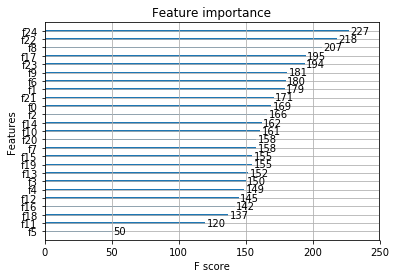

In [148]:
plot_importance(xreg, max_num_features=50)

#### 25 + itml

In [96]:
clf = ITML_Supervised(num_constraints=1000, verbose=True, convergence_threshold=0.001)

In [97]:
x_train_sc.shape

(337, 25)

In [98]:
%%time
clf.fit(x_train_sc, y_train)

/home/artesby/anaconda3/envs/myenv/lib/python3.7/site-packages/metric_learn/constraints.py:62: UserWarning: Only generated 566 positive constraints (requested 1000)
  len(ab), 'positive' if same_label else 'negative', num_constraints))


itml iter: 0, conv = 12.257700
itml iter: 1, conv = 3.591601
itml iter: 2, conv = 2.246185
itml iter: 3, conv = 1.709264
itml iter: 4, conv = 1.423264
itml iter: 5, conv = 1.223823
itml iter: 6, conv = 1.087506
itml iter: 7, conv = 0.983216
itml iter: 8, conv = 0.898864
itml iter: 9, conv = 0.831640
itml iter: 10, conv = 0.774728
itml iter: 11, conv = 0.731870
itml iter: 12, conv = 0.690364
itml iter: 13, conv = 0.656431
itml iter: 14, conv = 0.624659
itml iter: 15, conv = 0.595801
itml iter: 16, conv = 0.572897
itml iter: 17, conv = 0.550198
itml iter: 18, conv = 0.529966
itml iter: 19, conv = 0.511145
itml iter: 20, conv = 0.493404
itml iter: 21, conv = 0.480161
itml iter: 22, conv = 0.469824
itml iter: 23, conv = 0.462531
itml iter: 24, conv = 0.456121
itml iter: 25, conv = 0.451301
itml iter: 26, conv = 0.444087
itml iter: 27, conv = 0.440911
itml iter: 28, conv = 0.438339
itml iter: 29, conv = 0.435649
itml iter: 30, conv = 0.433826
itml iter: 31, conv = 0.432751
itml iter: 32, co

itml iter: 260, conv = 0.057500
itml iter: 261, conv = 0.056316
itml iter: 262, conv = 0.055077
itml iter: 263, conv = 0.053891
itml iter: 264, conv = 0.052867
itml iter: 265, conv = 0.051884
itml iter: 266, conv = 0.050896
itml iter: 267, conv = 0.049953
itml iter: 268, conv = 0.048961
itml iter: 269, conv = 0.048151
itml iter: 270, conv = 0.047548
itml iter: 271, conv = 0.047073
itml iter: 272, conv = 0.046595
itml iter: 273, conv = 0.046000
itml iter: 274, conv = 0.045459
itml iter: 275, conv = 0.044919
itml iter: 276, conv = 0.044331
itml iter: 277, conv = 0.043989
itml iter: 278, conv = 0.043788
itml iter: 279, conv = 0.043609
itml iter: 280, conv = 0.043506
itml iter: 281, conv = 0.043408
itml iter: 282, conv = 0.043499
itml iter: 283, conv = 0.043545
itml iter: 284, conv = 0.043404
itml iter: 285, conv = 0.043229
itml iter: 286, conv = 0.043152
itml iter: 287, conv = 0.042952
itml iter: 288, conv = 0.042789
itml iter: 289, conv = 0.042575
itml iter: 290, conv = 0.042276
itml ite

itml iter: 524, conv = 0.003757
itml iter: 525, conv = 0.003747
itml iter: 526, conv = 0.003736
itml iter: 527, conv = 0.003714
itml iter: 528, conv = 0.003699
itml iter: 529, conv = 0.003682
itml iter: 530, conv = 0.003658
itml iter: 531, conv = 0.003636
itml iter: 532, conv = 0.003614
itml iter: 533, conv = 0.003576
itml iter: 534, conv = 0.003531
itml iter: 535, conv = 0.003479
itml iter: 536, conv = 0.003426
itml iter: 537, conv = 0.003367
itml iter: 538, conv = 0.003309
itml iter: 539, conv = 0.003259
itml iter: 540, conv = 0.003204
itml iter: 541, conv = 0.003141
itml iter: 542, conv = 0.003085
itml iter: 543, conv = 0.003040
itml iter: 544, conv = 0.003005
itml iter: 545, conv = 0.002977
itml iter: 546, conv = 0.002946
itml iter: 547, conv = 0.002914
itml iter: 548, conv = 0.002877
itml iter: 549, conv = 0.002843
itml iter: 550, conv = 0.002819
itml iter: 551, conv = 0.002807
itml iter: 552, conv = 0.002795
itml iter: 553, conv = 0.002780
itml iter: 554, conv = 0.002779
itml ite

ITML_Supervised(A0=None, bounds=None, convergence_threshold=0.001, gamma=1.0,
        max_iter=1000, num_constraints=1000, num_labeled=inf, verbose=True)

In [99]:
i_metric = metric(clf.metric())

In [100]:
%%time
test_dist_matrix = pdist(x_test_sc, metric=i_metric)

print(np.mean(r_precision_m(authors=y_test, matrix=pd.DataFrame(test_dist_matrix))))

0.2101879327398615
CPU times: user 502 ms, sys: 72 µs, total: 502 ms
Wall time: 500 ms


In [101]:
%%time
train_dist_matrix = pdist(x_train_sc, metric=i_metric)

print(np.mean(r_precision_m(authors=y_train, matrix=pd.DataFrame(train_dist_matrix))))

0.24480712166172106
CPU times: user 499 ms, sys: 7.96 ms, total: 507 ms
Wall time: 492 ms


#### 25 + lsml

In [102]:
clf = LSML_Supervised(num_constraints=10, verbose=True)

In [103]:
x_train_sc.shape

(337, 25)

In [104]:
np.linalg.det(np.cov((x_train_sc.T)))

1.4256993436072638e-22

In [105]:
%%time
clf.fit(x_train, y_train)

initial loss 298.527408424312
gradient norm 30.882785630722882
iter 1 cost 4.188748029887815 best step 0.07742636826811278
gradient norm 141771692.65391725
iter 2 cost -31.964475658481945 best step 1.0
gradient norm 85.8631656543225
iter 3 cost -31.964475658481945 best step 6.056439338981824e-07
CPU times: user 112 ms, sys: 4.3 ms, total: 116 ms
Wall time: 33.4 ms


LSML_Supervised(max_iter=1000, num_constraints=10, num_labeled=inf,
        prior=None, tol=0.001, verbose=True, weights=None)

In [106]:
l_metric = metric(clf.metric())

In [107]:
%%time
test_dist_matrix = pdist(x_test, metric=l_metric)

print(np.mean(r_precision_m(authors=y_test, matrix=pd.DataFrame(test_dist_matrix))))

0.09446092977250246
CPU times: user 507 ms, sys: 130 µs, total: 507 ms
Wall time: 506 ms


In [108]:
%%time
train_dist_matrix = pdist(x_train, metric=l_metric)

print(np.mean(r_precision_m(authors=y_train, matrix=pd.DataFrame(train_dist_matrix))))

0.08778437190900099
CPU times: user 507 ms, sys: 4.07 ms, total: 511 ms
Wall time: 503 ms


### Most Frequent Words

In [56]:
qq1 = sorted([q.rsplit('.', 1)[0] for q in os.listdir('parsed_json_cut_chunks16')])

In [57]:
qq2 = sorted([q for q in os.listdir("txt_cut_chunks15")])

In [27]:
k = 2000

In [34]:
%%time
data = []
lengths = []
# lengths = Counter()
for filename in sorted(os.listdir("txt_cut_chunks15")):
    fbusta_id = int(filename.split('.')[0])
    if get_author_id(fbusta_id, catalog) in singles:
        continue
    with codecs.open(os.path.join("txt_cut_chunks15", filename), encoding='utf-8') as book:
        content = book.read()
        data.append(content)
        lengths.append(len(re.findall(u"(?u)\\b\\w+\\b", content)))
#         lengths[get_book_id(fbusta_id, catalog)] += len(re.findall(u"(?u)\\b\\w+\\b", content))
# lengths = np.array(list(map(lambda t: lengths[t], book_ids)))

CPU times: user 3.43 s, sys: 155 ms, total: 3.58 s
Wall time: 3.68 s


In [35]:
len(data)

2338

In [37]:
len(authors)

2338

In [38]:
train_idx, test_idx = train_test_split(np.array(data), authors, return_idx=True, mod='s')
book_ids_train, book_ids_test = book_ids[train_idx], book_ids[test_idx]
data_train = np.array(data)[train_idx]
authors_train = authors[train_idx]
len_train = np.array(lengths)[train_idx]

test_fraction: 0.5055603079555175


In [71]:
#for 3pos

data = []
lengths = []
for filename in sorted(os.listdir(dir_in_parsed)):
    book_id = int(filename.split('.')[0])
    if get_author_id(book_id, catalog) in singles:
        continue
    with codecs.open(os.path.join(dir_in_parsed, filename), encoding='utf-8') as book:
        content = book.read()
        data.append(content)
        lengths.append(len(re.findall(u"(?u)\\b\\w+\\b", content)))

train_idx, test_idx = train_test_split(np.array(data), authors, return_idx=True, mod='s')
data_train = np.array(data)[train_idx]
authors_train = authors[train_idx]
len_train = np.array(lengths)[train_idx]

test_fraction: 0.5051194539249146


In [76]:
%%time
tri_grams, cv_tri_grams = count_n_grams(data_train, n=3, stopgrams=stop3grams, max_features=2000) #5700

CPU times: user 19.4 s, sys: 348 ms, total: 19.8 s
Wall time: 19.8 s


In [77]:
tri_grams

<1184x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 53872 stored elements in Compressed Sparse Row format>

In [478]:
td = pd.DataFrame(cv_tri_grams.transform(data_train).todense())
td.columns = sorted(cv_tri_grams.vocabulary_) 
freqs = td.div(len_train, axis=0)
sclr = StandardScaler().fit(freqs)
freqs_sc = sclr.transform(freqs)
cosine_delta = pd.DataFrame(pdist(freqs_sc, metric='cosine') / k)
b_delta = pd.DataFrame(pdist(freqs_sc, metric='manhattan') / k)
np.mean(r_precision_m(cosine_delta, authors_train)), np.mean(r_precision_m(b_delta, authors_train))

(0.4146884272997033, 0.4000989119683481)

In [479]:
data_test = np.array(data)[test_idx]
authors_test = authors[test_idx]
len_test = np.array(lengths)[test_idx]

In [480]:
td = pd.DataFrame(cv_tri_grams.transform(data_test).todense())
td.columns = sorted(cv_tri_grams.vocabulary_)

freqs_test = td.div(len_test, axis=0)
freqs_test_sc = sclr.transform(freqs_test)
cosine_delta_test = pd.DataFrame(pdist(freqs_test_sc, metric='cosine') / k)
b_delta_test = pd.DataFrame(pdist(freqs_test_sc, metric='manhattan') / k)
np.mean(r_precision_m(cosine_delta_test, authors_test)), np.mean(r_precision_m(b_delta_test, authors_test))

(0.4047972304648863, 0.3852621167161227)

#### delta

In [355]:
lara_mfw = pd.read_csv('mfw.txt', header=None, sep=' ')[0].values[:k]
lara_mfw

array(['и', 'в', 'не', 'на', 'что', 'с', 'я', 'он', 'а', 'как', 'но',
       'его', 'к', 'это', 'она', 'все', 'по', 'у', 'из', 'за', 'так',
       'от', 'ее', 'ты', 'же', 'было', 'о', 'бы', 'меня', 'мне', 'они',
       'только', 'мы', 'то', 'еще', 'когда', 'если', 'был', 'для', 'вы',
       'чтобы', 'уже', 'их', 'до', 'или', 'ему', 'да', 'даже', 'ни',
       'нет', 'вот', 'была', 'себя', 'него', 'сказал', 'может', 'чем',
       'время', 'были', 'со', 'очень', 'ли', 'под', 'там', 'раз', 'тебя',
       'есть', 'ей', 'теперь', 'того', 'быть', 'где', 'будет', 'ничего',
       'потом', 'во', 'этого', 'нас', 'тебе', 'здесь', 'этот', 'себе',
       'тут', 'после', 'сейчас', 'этом', 'просто', 'кто', 'без', 'больше',
       'можно', 'ну', 'через', 'них', 'том', 'вас', 'при', 'тоже', 'один',
       'надо'], dtype=object)

In [39]:
%%time
cv_mfw = CountVectorizer(max_features=k, token_pattern=u"(?u)\\b\\w+\\b").fit(data_train)
td = pd.DataFrame(cv_mfw.transform(data_train).todense())
td.columns = sorted(cv_mfw.vocabulary_) 

CPU times: user 4.5 s, sys: 30.3 ms, total: 4.53 s
Wall time: 4.53 s


In [40]:
freqs = td.div(len_train, axis=0)
sclr = StandardScaler().fit(freqs)
freqs_sc = sclr.transform(freqs)
cosine_delta = pd.DataFrame(pdist(freqs_sc, metric='cosine') / k)
b_delta = pd.DataFrame(pdist(freqs_sc, metric='manhattan') / k)

In [41]:
np.mean(r_precision_m(cosine_delta, authors_train)), np.mean(r_precision_m(b_delta, authors_train))

(0.34580925513666627, 0.15746084147099373)

In [73]:
data_test = np.array(data)[test_idx]
authors_test = authors[test_idx]
len_test = np.array(lengths)[test_idx]

In [74]:
td = pd.DataFrame(cv_mfw.transform(data_test).todense())
td.columns = sorted(cv_mfw.vocabulary_)
freqs_test = td.div(len_test, axis=0)
freqs_test_sc = sclr.transform(freqs_test)
cosine_delta_test = pd.DataFrame(pdist(freqs_test_sc, metric='cosine') / k)
b_delta_test = pd.DataFrame(pdist(freqs_test_sc, metric='manhattan') / k)

In [75]:
np.mean(r_precision_m(cosine_delta_test, authors_test)), np.mean(r_precision_m(b_delta_test, authors_test))

(0.3276719793308973, 0.15158586951697686)

In [76]:
book_names[test_idx[3]]

'Дом'

In [77]:
get_author_name(book_fbusta_ids[test_idx[3]], catalog), get_book_name(book_fbusta_ids[test_idx[3]], catalog)

('Абрамов', 'Дом')

In [78]:
[(get_author_name(book_fbusta_ids[x], catalog), get_book_name(book_fbusta_ids[x], catalog)) for x in test_idx[cosine_delta_test[0].argsort()[:15]]]

[('Абрамов', 'Братья и сестры'),
 ('Решетников', 'Подлиповцы'),
 ('Васильев', 'Не стреляйте белых лебедей'),
 ('Гладков', 'Маша из Заполья'),
 ('Пелевин', 'Тайные виды на гору Фудзи'),
 ('Гладков', 'Маша из Заполья'),
 ('Петров', 'Двенадцать стульев'),
 ('Абрамов', 'Пути-перепутья'),
 ('Дудинцев', 'Белые одежды'),
 ('Стругацкий', 'Улитка на склоне'),
 ('Абрамов', 'Пути-перепутья'),
 ('Белов', 'Привычное дело'),
 ('Крюков', 'Новым строем'),
 ('Дудинцев', 'Белые одежды'),
 ('Абрамов', 'Дом')]

In [68]:
dic = {}
for i in cosine_delta_test:
    col = cosine_delta_test[i]
    closest = test_idx[col.argsort()[:15].values]
    arr = [(get_author_name(book_fbusta_ids[x], catalog), get_book_name(book_fbusta_ids[x], catalog)) for x in closest]
    dic[arr[0]] = arr[1:]

In [69]:
from pprint import pprint
stream = open('cosine_delta_similarity_chunks15_2kMFW', 'w')
pprint(dic, stream)

#### delta + xgb

In [79]:
np.random.seed(17)

y_train = authors_train
y_test = authors_test
x_train_sc = freqs_sc
x_test_sc = freqs_test_sc
CLOSE = 0
MID = 1
FAR = 2
positive = []
labels_positive = []
for i, x1 in enumerate(x_train_sc):
    for j, x2 in enumerate(x_train_sc):
        if book_ids_train[i] == book_ids_train[j] and i != j:
            positive.append(
                np.abs(x1 - x2)
            )
            labels_positive.append(CLOSE)
        elif y_train[i] == y_train[j] and i != j:
            positive.append(
                np.abs(x1 - x2)
            )
            labels_positive.append(MID)

negative = []
labels_negative = []
while len(negative) < len(positive):
    idx1, idx2 = np.random.choice(len(y_train), 2, replace=False)
    if y_train[idx1] == y_train[idx2]:
        continue
    negative.append(
        np.abs(x_train_sc[idx1] - x_train_sc[idx2])
    )
    labels_negative.append(FAR)

data_train = [*positive, *negative]
labels_train = [*labels_positive, *labels_negative]

positive_test = []
labels_positive_test = []
for i, x1 in enumerate(x_test_sc):
    for j, x2 in enumerate(x_test_sc):
        if book_ids_test[i] == book_ids_test[j] and i != j:
            positive_test.append(
                np.abs(x1 - x2)
            )
            labels_positive_test.append(CLOSE)
        elif y_test[i] == y_test[j] and i != j:
            positive_test.append(
                np.abs(x1 - x2)
            )
            labels_positive_test.append(MID)
            
negative_test = []
labels_negative_test = []
while len(negative_test) < len(positive_test):
    idx1, idx2 = np.random.choice(len(y_test), 2, replace=False)
    if y_test[idx1] == y_test[idx2]:
        continue
    negative_test.append(
        np.abs(x_test_sc[idx1] - x_test_sc[idx2])
    )
    labels_negative_test.append(FAR)
    
data_test = [*positive_test, *negative_test]
labels_test = [*labels_positive_test, *labels_negative_test]

eval_set = [(data_train, labels_train), (data_test, labels_test)]

In [80]:
%%time
eu_train_matrix = pdist(x_train_sc)
eu_test_matrix = pdist(x_test_sc)
print("eu train rpec:", np.mean(r_precision_m(matrix=pd.DataFrame(eu_train_matrix), authors=y_train)))
print("eu test rpec:", np.mean(r_precision_m(matrix=pd.DataFrame(eu_test_matrix), authors=y_test)))

eu train rpec: 0.12987700404226185
eu test rpec: 0.1213423962155999
CPU times: user 7.04 s, sys: 71.8 ms, total: 7.12 s
Wall time: 6.13 s


In [81]:
xreg = XGBRegressor(objective ='reg:linear', n_jobs=1, booster='gbtree', n_estimators=2000, subsample=0.7)

In [82]:
%%time
xreg.fit(data_train,labels_train, eval_set=eval_set, early_stopping_rounds=200)

[0]	validation_0-rmse:1.0396	validation_1-rmse:1.03964
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 200 rounds.
[1]	validation_0-rmse:0.97107	validation_1-rmse:0.971262
[2]	validation_0-rmse:0.912059	validation_1-rmse:0.912285
[3]	validation_0-rmse:0.860604	validation_1-rmse:0.860901
[4]	validation_0-rmse:0.81657	validation_1-rmse:0.817104
[5]	validation_0-rmse:0.778487	validation_1-rmse:0.779105
[6]	validation_0-rmse:0.746246	validation_1-rmse:0.747896
[7]	validation_0-rmse:0.718136	validation_1-rmse:0.720209
[8]	validation_0-rmse:0.694569	validation_1-rmse:0.697
[9]	validation_0-rmse:0.674616	validation_1-rmse:0.677632
[10]	validation_0-rmse:0.657625	validation_1-rmse:0.660936
[11]	validation_0-rmse:0.643257	validation_1-rmse:0.646963
[12]	validation_0-rmse:0.630815	validation_1-rmse:0.635228
[13]	validation_0-rmse:0.620182	validation_1-rmse:0.624794
[14]	validation_0-rmse:0.610968	

[137]	validation_0-rmse:0.445094	validation_1-rmse:0.512667
[138]	validation_0-rmse:0.4445	validation_1-rmse:0.512461
[139]	validation_0-rmse:0.443901	validation_1-rmse:0.512285
[140]	validation_0-rmse:0.443337	validation_1-rmse:0.511976
[141]	validation_0-rmse:0.442684	validation_1-rmse:0.5118
[142]	validation_0-rmse:0.442082	validation_1-rmse:0.511611
[143]	validation_0-rmse:0.441381	validation_1-rmse:0.511313
[144]	validation_0-rmse:0.440631	validation_1-rmse:0.511118
[145]	validation_0-rmse:0.439982	validation_1-rmse:0.510982
[146]	validation_0-rmse:0.439178	validation_1-rmse:0.51047
[147]	validation_0-rmse:0.438672	validation_1-rmse:0.510331
[148]	validation_0-rmse:0.438025	validation_1-rmse:0.510155
[149]	validation_0-rmse:0.437369	validation_1-rmse:0.509904
[150]	validation_0-rmse:0.436828	validation_1-rmse:0.509878
[151]	validation_0-rmse:0.436098	validation_1-rmse:0.509796
[152]	validation_0-rmse:0.435483	validation_1-rmse:0.509588
[153]	validation_0-rmse:0.434787	validation_1

[275]	validation_0-rmse:0.377817	validation_1-rmse:0.495777
[276]	validation_0-rmse:0.377453	validation_1-rmse:0.495725
[277]	validation_0-rmse:0.377007	validation_1-rmse:0.495631
[278]	validation_0-rmse:0.376708	validation_1-rmse:0.495453
[279]	validation_0-rmse:0.376294	validation_1-rmse:0.495336
[280]	validation_0-rmse:0.375989	validation_1-rmse:0.495231
[281]	validation_0-rmse:0.375557	validation_1-rmse:0.495203
[282]	validation_0-rmse:0.375112	validation_1-rmse:0.49518
[283]	validation_0-rmse:0.374803	validation_1-rmse:0.495063
[284]	validation_0-rmse:0.374371	validation_1-rmse:0.494934
[285]	validation_0-rmse:0.373923	validation_1-rmse:0.494738
[286]	validation_0-rmse:0.373598	validation_1-rmse:0.494645
[287]	validation_0-rmse:0.373233	validation_1-rmse:0.494713
[288]	validation_0-rmse:0.372995	validation_1-rmse:0.494712
[289]	validation_0-rmse:0.372563	validation_1-rmse:0.494816
[290]	validation_0-rmse:0.372293	validation_1-rmse:0.494831
[291]	validation_0-rmse:0.371945	validati

[413]	validation_0-rmse:0.334279	validation_1-rmse:0.488648
[414]	validation_0-rmse:0.333981	validation_1-rmse:0.488633
[415]	validation_0-rmse:0.333675	validation_1-rmse:0.488568
[416]	validation_0-rmse:0.333313	validation_1-rmse:0.488483
[417]	validation_0-rmse:0.333071	validation_1-rmse:0.488509
[418]	validation_0-rmse:0.332735	validation_1-rmse:0.488486
[419]	validation_0-rmse:0.332447	validation_1-rmse:0.488484
[420]	validation_0-rmse:0.332254	validation_1-rmse:0.488514
[421]	validation_0-rmse:0.33203	validation_1-rmse:0.488497
[422]	validation_0-rmse:0.331707	validation_1-rmse:0.488463
[423]	validation_0-rmse:0.331466	validation_1-rmse:0.488473
[424]	validation_0-rmse:0.331245	validation_1-rmse:0.488426
[425]	validation_0-rmse:0.331049	validation_1-rmse:0.48835
[426]	validation_0-rmse:0.33073	validation_1-rmse:0.488327
[427]	validation_0-rmse:0.330431	validation_1-rmse:0.488166
[428]	validation_0-rmse:0.330089	validation_1-rmse:0.4882
[429]	validation_0-rmse:0.329916	validation_1

[550]	validation_0-rmse:0.300827	validation_1-rmse:0.485112
[551]	validation_0-rmse:0.300614	validation_1-rmse:0.485121
[552]	validation_0-rmse:0.300365	validation_1-rmse:0.485078
[553]	validation_0-rmse:0.300176	validation_1-rmse:0.484973
[554]	validation_0-rmse:0.299986	validation_1-rmse:0.484935
[555]	validation_0-rmse:0.299728	validation_1-rmse:0.484883
[556]	validation_0-rmse:0.299546	validation_1-rmse:0.484823
[557]	validation_0-rmse:0.29928	validation_1-rmse:0.484813
[558]	validation_0-rmse:0.299049	validation_1-rmse:0.484759
[559]	validation_0-rmse:0.298833	validation_1-rmse:0.484759
[560]	validation_0-rmse:0.298607	validation_1-rmse:0.484748
[561]	validation_0-rmse:0.298346	validation_1-rmse:0.484696
[562]	validation_0-rmse:0.29808	validation_1-rmse:0.484668
[563]	validation_0-rmse:0.297892	validation_1-rmse:0.48468
[564]	validation_0-rmse:0.297631	validation_1-rmse:0.484694
[565]	validation_0-rmse:0.297376	validation_1-rmse:0.484624
[566]	validation_0-rmse:0.297128	validation

[688]	validation_0-rmse:0.273798	validation_1-rmse:0.483196
[689]	validation_0-rmse:0.273604	validation_1-rmse:0.483199
[690]	validation_0-rmse:0.273437	validation_1-rmse:0.483179
[691]	validation_0-rmse:0.273209	validation_1-rmse:0.483241
[692]	validation_0-rmse:0.273008	validation_1-rmse:0.483254
[693]	validation_0-rmse:0.272904	validation_1-rmse:0.483268
[694]	validation_0-rmse:0.272764	validation_1-rmse:0.483264
[695]	validation_0-rmse:0.272565	validation_1-rmse:0.483294
[696]	validation_0-rmse:0.272381	validation_1-rmse:0.483332
[697]	validation_0-rmse:0.272213	validation_1-rmse:0.483356
[698]	validation_0-rmse:0.271976	validation_1-rmse:0.483277
[699]	validation_0-rmse:0.271806	validation_1-rmse:0.483221
[700]	validation_0-rmse:0.271679	validation_1-rmse:0.483214
[701]	validation_0-rmse:0.271471	validation_1-rmse:0.483175
[702]	validation_0-rmse:0.271286	validation_1-rmse:0.483142
[703]	validation_0-rmse:0.271138	validation_1-rmse:0.483122
[704]	validation_0-rmse:0.270991	validat

[825]	validation_0-rmse:0.250888	validation_1-rmse:0.482637
[826]	validation_0-rmse:0.250703	validation_1-rmse:0.482569
[827]	validation_0-rmse:0.250528	validation_1-rmse:0.482588
[828]	validation_0-rmse:0.25035	validation_1-rmse:0.482475
[829]	validation_0-rmse:0.250194	validation_1-rmse:0.482527
[830]	validation_0-rmse:0.250096	validation_1-rmse:0.482517
[831]	validation_0-rmse:0.249984	validation_1-rmse:0.482531
[832]	validation_0-rmse:0.249861	validation_1-rmse:0.48253
[833]	validation_0-rmse:0.249718	validation_1-rmse:0.48255
[834]	validation_0-rmse:0.249569	validation_1-rmse:0.482487
[835]	validation_0-rmse:0.249357	validation_1-rmse:0.482468
[836]	validation_0-rmse:0.249168	validation_1-rmse:0.482477
[837]	validation_0-rmse:0.249031	validation_1-rmse:0.482503
[838]	validation_0-rmse:0.248862	validation_1-rmse:0.482455
[839]	validation_0-rmse:0.248735	validation_1-rmse:0.482473
[840]	validation_0-rmse:0.248595	validation_1-rmse:0.482417
[841]	validation_0-rmse:0.248441	validation

[962]	validation_0-rmse:0.230918	validation_1-rmse:0.482626
[963]	validation_0-rmse:0.230826	validation_1-rmse:0.482645
[964]	validation_0-rmse:0.230659	validation_1-rmse:0.482671
[965]	validation_0-rmse:0.230544	validation_1-rmse:0.482661
[966]	validation_0-rmse:0.230412	validation_1-rmse:0.482619
[967]	validation_0-rmse:0.230273	validation_1-rmse:0.482646
[968]	validation_0-rmse:0.230108	validation_1-rmse:0.482644
[969]	validation_0-rmse:0.229987	validation_1-rmse:0.482611
[970]	validation_0-rmse:0.229869	validation_1-rmse:0.482655
[971]	validation_0-rmse:0.229719	validation_1-rmse:0.482732
[972]	validation_0-rmse:0.229579	validation_1-rmse:0.482724
[973]	validation_0-rmse:0.229486	validation_1-rmse:0.482722
[974]	validation_0-rmse:0.229341	validation_1-rmse:0.482706
[975]	validation_0-rmse:0.229216	validation_1-rmse:0.482743
[976]	validation_0-rmse:0.229092	validation_1-rmse:0.482706
[977]	validation_0-rmse:0.228997	validation_1-rmse:0.482654
[978]	validation_0-rmse:0.228867	validat

[1098]	validation_0-rmse:0.213208	validation_1-rmse:0.482393
[1099]	validation_0-rmse:0.213083	validation_1-rmse:0.482406
[1100]	validation_0-rmse:0.212924	validation_1-rmse:0.482401
[1101]	validation_0-rmse:0.21282	validation_1-rmse:0.482431
[1102]	validation_0-rmse:0.212696	validation_1-rmse:0.482428
[1103]	validation_0-rmse:0.212589	validation_1-rmse:0.482455
[1104]	validation_0-rmse:0.212453	validation_1-rmse:0.482453
[1105]	validation_0-rmse:0.212331	validation_1-rmse:0.482418
[1106]	validation_0-rmse:0.212275	validation_1-rmse:0.482432
[1107]	validation_0-rmse:0.212182	validation_1-rmse:0.482409
[1108]	validation_0-rmse:0.212074	validation_1-rmse:0.482451
Stopping. Best iteration:
[908]	validation_0-rmse:0.238535	validation_1-rmse:0.482143

CPU times: user 18min 39s, sys: 1.85 s, total: 18min 41s
Wall time: 18min 41s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=2000, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.7)

In [83]:
%%time
dist_xgb_train = np.zeros((len(x_train_sc), len(x_train_sc)))
for i, x1 in enumerate(x_train_sc):
    for j, x2 in enumerate(x_train_sc):
        if dist_xgb_train[i][j] == 0:
            p = xreg.predict(np.abs([x1 - x2]))[0]
            dist_xgb_train[i][j] = p
            dist_xgb_train[j][i] = p

print("xgb train rpec:", np.mean(r_precision_m(matrix=pd.DataFrame(dist_xgb_train), authors=y_train)))

dist_xgb_test = np.zeros((len(x_test_sc), len(x_test_sc)))
for i, x1 in enumerate(x_test_sc):
    for j, x2 in enumerate(x_test_sc):
        if dist_xgb_test[i][j] == 0:
            p = xreg.predict(np.abs([x1 - x2]))[0]
            dist_xgb_test[i][j] = p
            dist_xgb_test[j][i] = p

print("xgb test rpec:", np.mean(r_precision_m(matrix=pd.DataFrame(dist_xgb_test), authors=y_test)))

xgb train rpec: 0.11699949693398552
xgb test rpec: 0.0751075858958361
CPU times: user 16min 2s, sys: 140 ms, total: 16min 2s
Wall time: 16min 2s


In [169]:
dic = {}
dists = pd.DataFrame(dist_xgb_test)
for i in dists:
    col = dists[i]
    closest = test_idx[col.argsort()[:15]]
    arr = [(get_author_name(book_fbusta_ids[x], catalog), get_book_name(book_fbusta_ids[x], catalog)) for x in closest]
    dic[arr[0]] = arr[1:]
from pprint import pprint
stream = open('xgb_delta_similarity_chunks15_2kMFW_stratified', 'w')
pprint(dic, stream)

#### delta + itml

In [368]:
np.eye(3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [372]:
clf = ITML_Supervised(num_constraints=900, verbose=True, convergence_threshold=0.0001)

In [373]:
%%time
clf.fit(x_train_sc, y_train)

itml iter: 0, conv = 21.942314
itml iter: 1, conv = 5.927483
itml iter: 2, conv = 4.143769
itml iter: 3, conv = 3.268984
itml iter: 4, conv = 2.821780
itml iter: 5, conv = 2.500896
itml iter: 6, conv = 2.241373
itml iter: 7, conv = 1.921770
itml iter: 8, conv = 1.658593
itml iter: 9, conv = 1.401144
itml iter: 10, conv = 1.027116
itml iter: 11, conv = 0.683538
itml iter: 12, conv = 0.497288
itml iter: 13, conv = 0.410995
itml iter: 14, conv = 0.340519
itml iter: 15, conv = 0.266183
itml iter: 16, conv = 0.193173
itml iter: 17, conv = 0.143563
itml iter: 18, conv = 0.119489
itml iter: 19, conv = 0.098666
itml iter: 20, conv = 0.076380
itml iter: 21, conv = 0.054629
itml iter: 22, conv = 0.039940
itml iter: 23, conv = 0.032888
itml iter: 24, conv = 0.027298
itml iter: 25, conv = 0.021417
itml iter: 26, conv = 0.015470
itml iter: 27, conv = 0.011262
itml iter: 28, conv = 0.009194
itml iter: 29, conv = 0.007639
itml iter: 30, conv = 0.006042
itml iter: 31, conv = 0.004379
itml iter: 32, co

ITML_Supervised(A0=None, bounds=None, convergence_threshold=0.0001, gamma=1.0,
        max_iter=1000, num_constraints=900, num_labeled=inf, verbose=True)

In [374]:
i_metric = metric(clf.metric())

In [375]:
%%time
train_dist_matrix = pdist(x_train_sc, metric=i_metric)

print(np.mean(r_precision_m(authors=y_train, matrix=pd.DataFrame(train_dist_matrix))))

0.5897505217226333
CPU times: user 1.33 s, sys: 3.79 ms, total: 1.33 s
Wall time: 1.34 s


In [376]:
%%time
test_dist_matrix = pdist(x_test_sc, metric=i_metric)

print(np.mean(r_precision_m(authors=y_test, matrix=pd.DataFrame(test_dist_matrix))))

0.39405797101449275
CPU times: user 122 ms, sys: 0 ns, total: 122 ms
Wall time: 122 ms


#### delta + lsml

In [298]:
x_train_sc

array([[-1.30888854,  0.2702789 , -0.40076212, ..., -0.23626613,
        -0.55487229,  0.45985542],
       [-0.9122457 , -0.08889377,  0.46908537, ...,  0.0156277 ,
         0.07632148,  0.62500745],
       [-0.65525592,  0.59707722, -0.05663998, ...,  0.16153021,
         0.81265258,  0.70071264],
       ...,
       [-0.62523203, -1.51177972, -0.6590426 , ...,  0.17127919,
         1.9326877 , -0.29624269],
       [ 2.18683835, -0.71133972, -0.07717716, ..., -0.69174114,
        -0.54600199, -0.13634111],
       [ 2.33773995, -1.3171795 , -0.03540123, ...,  3.47989067,
        -0.5873353 ,  0.89297354]])

In [299]:
np.linalg.det(np.cov(x_train_sc.T))

8.782767802394456e-28

In [300]:
np.eye(3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [377]:
clf = LSML_Supervised(num_constraints=1990,verbose=True, prior=np.eye(x_train_sc.T.shape[0]), )

In [378]:
%%time
clf.fit(x_train_sc, y_train)

initial loss 101.69612002457745
gradient norm 2117.8686985471927
iter 1 cost 101.43352503758751 best step 1.0
gradient norm 1267.3907158735417
iter 2 cost 101.43352503758751 best step 0.5984274269424452
CPU times: user 595 ms, sys: 4.24 ms, total: 600 ms
Wall time: 198 ms


/home/artesby/anaconda3/envs/myenv/lib/python3.7/site-packages/metric_learn/constraints.py:62: UserWarning: Only generated 1754 positive constraints (requested 1990)
  len(ab), 'positive' if same_label else 'negative', num_constraints))


LSML_Supervised(max_iter=1000, num_constraints=1990, num_labeled=inf,
        prior=array([[1., 0., ..., 0., 0.],
       [0., 1., ..., 0., 0.],
       ...,
       [0., 0., ..., 1., 0.],
       [0., 0., ..., 0., 1.]]),
        tol=0.001, verbose=True, weights=None)

In [379]:
l_metric = metric(clf.metric())

In [380]:
%%time
train_dist_matrix = pdist(x_train_sc, metric=l_metric)

print(np.mean(r_precision_m(authors=y_train, matrix=pd.DataFrame(train_dist_matrix))))

0.3263991652437868
CPU times: user 1.89 s, sys: 8.06 ms, total: 1.89 s
Wall time: 1.35 s


In [381]:
%%time
test_dist_matrix = pdist(x_test_sc, metric=l_metric)

print(np.mean(r_precision_m(authors=y_test, matrix=pd.DataFrame(test_dist_matrix))))

0.4652173913043478
CPU times: user 126 ms, sys: 0 ns, total: 126 ms
Wall time: 126 ms


### baseline

In [805]:
from math import factorial as fa

In [806]:
def partial_factorial(begin, end):
    s = 1
    for i in range(begin, end+1):
        s *= i
    return s
pfa = partial_factorial

In [807]:
def E_r_precision(n_books, n_relevant):
    n = n_books
    x = n_relevant
    s = 0
    c = fa(x) * fa(x) / pfa(n-x+1, n)
    for k in range(x+1):
        s += (k) * pfa(n-x-k+1, n-x) / fa(k) / fa(k) / fa(x-k)
    return c * s

In [808]:
5 - E_r_precision(500, 5)

0.04999999999999982

? = n_relevant * n_relevant / n_books

In [809]:
def estimation(n_books, n_relevant):
    return n_relevant * n_relevant / n_books

In [810]:
rps = []
for author in y_train:
    rps.append(estimation(len(y_train), (y_train==author).sum()))
print("train E rp:", np.mean(rps))

rps = []
for author in y_test:
    rps.append(estimation(len(y_test), (y_test==author).sum()))
print("test E rp:", np.mean(rps))


train E rp: 0.04813415660068887
test E rp: 0.19243856332703216


### some correlations

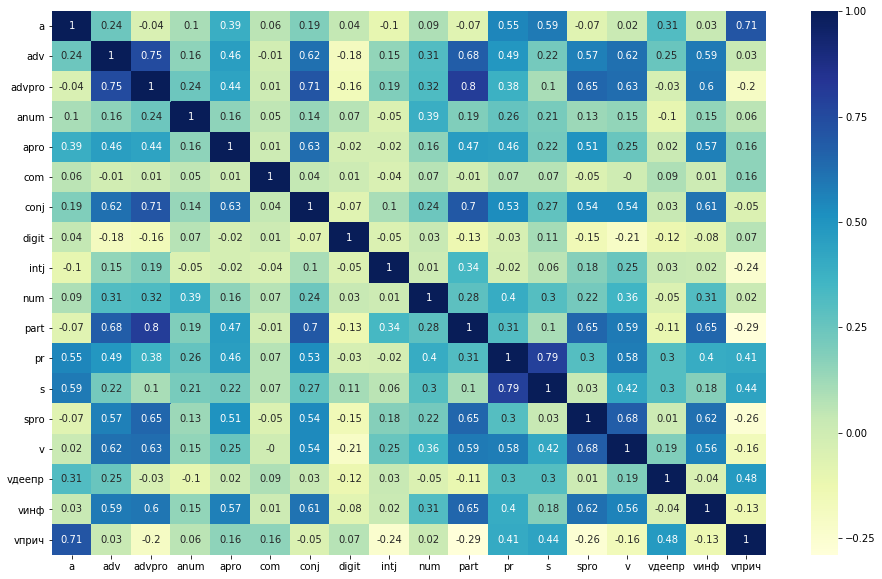

In [311]:
from seaborn import heatmap
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16,10))    
df = pd.DataFrame(pos_fractions.toarray())
df.columns = sorted(cv_fractions.vocabulary_)
heatmap(df.corr().round(2), annot=True, cmap="YlGnBu")

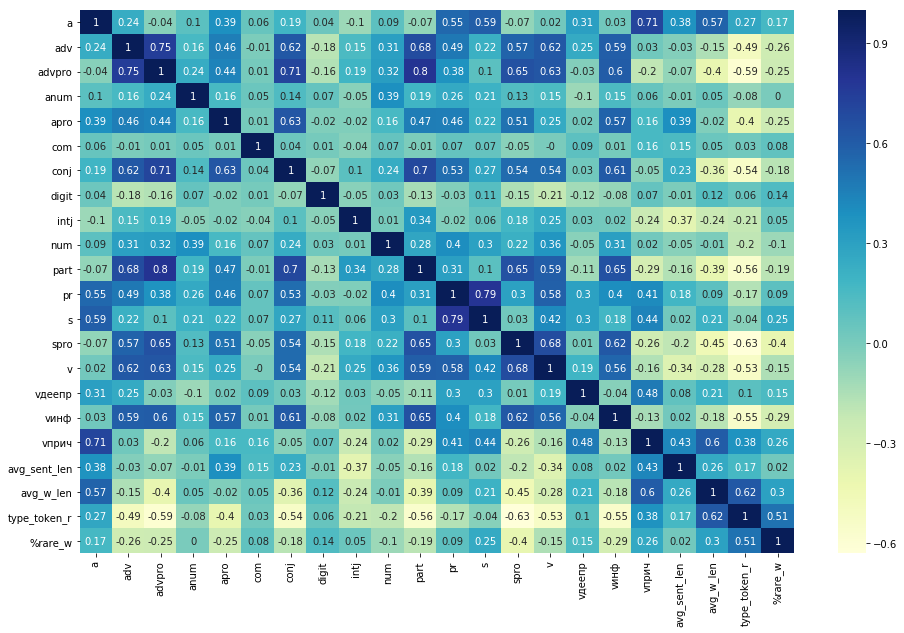

In [63]:
fig, ax = plt.subplots(figsize=(16,10))    
df = pd.DataFrame(np.c_[pos_fractions.todense(), avg_sent_l, avg_len_word, type_token_ratio, rwf])
df.columns = sorted(cv_fractions.vocabulary_)+ ['avg_sent_len', 'avg_w_len', 'type_token_r', '%rare_w']
heatmap(df.corr().round(2), annot=True, cmap="YlGnBu")